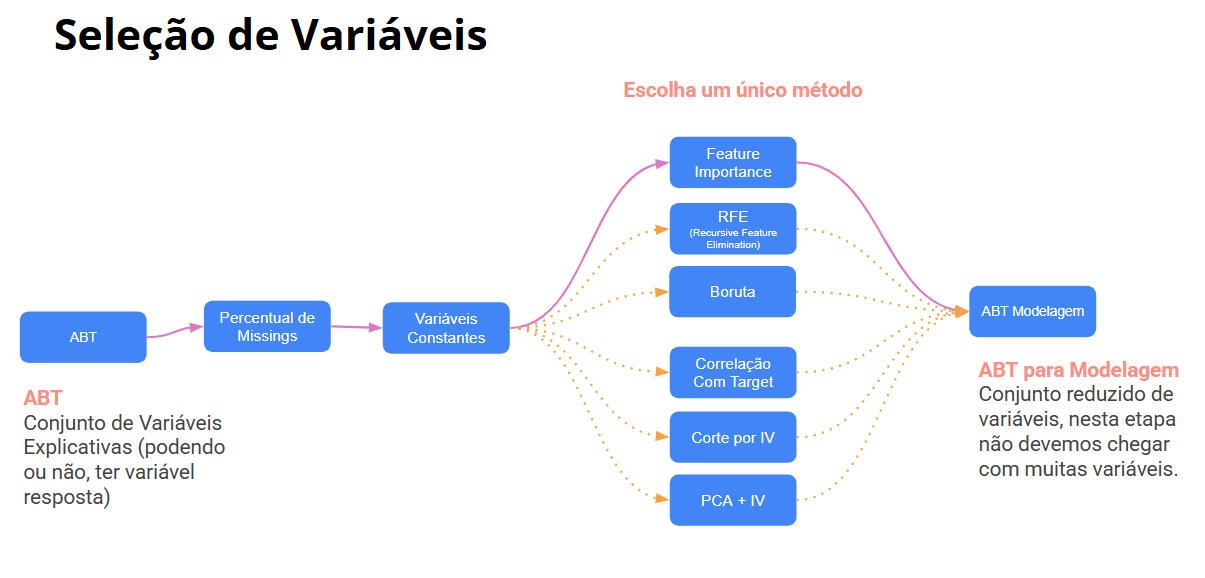

## Feature Importance com Gradient Boosting

Treinamos um GradientBoostingClassifier (árvore de decisão “aditiva”) e usamos feature_importances_ para medir a contribuição relativa de cada coluna transformada. Para interpretar no nível variável original, agregamos importâncias de todas as dummies do mesmo campo (derivadas do One-Hot).

In [ ]:
import joblib
# === 1) Carregar o dicionário de preprocessamento ===
preprocess_artifacts = joblib.load("/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/preprocess_telco.joblib")

# Agora você pode acessar cada item:
preprocess = preprocess_artifacts["preprocess"]
feature_names = preprocess_artifacts["feature_names"]
num_cols = preprocess_artifacts["num_cols"]
cat_baixa = preprocess_artifacts["cat_baixa"]
cat_alta = preprocess_artifacts["cat_alta"]
params = preprocess_artifacts["params"]

print("Colunas numéricas:", num_cols)
print("Parâmetros:", params)

Colunas numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Parâmetros: {'ESCALA_NUMERICA': 'padronizacao', 'LIMIAR_CARDINALIDADE': 12, 'TARGET_COL': 'Churn', 'ID_COLS': ['customerID']}


In [ ]:
# === 2) Carregar o split do dataset ===
ABT_train, ABT_test, y_train, y_test = joblib.load("/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/abt_split.joblib")

print("Train:", ABT_train.shape, " Test:", ABT_test.shape)
print("y_train:", y_train.shape, " y_test:", y_test.shape)

Train: (5634, 45)  Test: (1409, 45)
y_train: (5634,)  y_test: (1409,)


In [ ]:
ABT_train

array([[-0.44177295,  0.10237124, -0.52197565, ...,  0.        ,
         1.        ,  0.        ],
       [-0.44177295, -0.71174346,  0.33747781, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44177295, -0.79315493, -0.80901319, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 2.2636062 , -0.30468611,  1.25666162, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44177295, -0.34539184, -1.47766135, ...,  1.        ,
         0.        ,  0.        ],
       [-0.44177295, -1.07809507, -1.46936546, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
# ===== 3) Importância via Gradient Boosting =====
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np

gb = GradientBoostingClassifier(random_state=42)
gb.fit(ABT_train, y_train)

imp = pd.Series(gb.feature_importances_, index=feature_names).sort_values(ascending=False)

# agregação por variável original (colunas one-hot têm prefixo "col_valor")
def origem(col):
    # se veio do OHE, ohe retorna 'col_valor' — pegamos tudo antes do primeiro '_'
    if ("_" in col) and (col.split("_")[0] in cat_baixa):
        return col.split("_")[0]
    return col

imp_by_var = imp.groupby(imp.index.map(origem)).sum().sort_values(ascending=False)
top_gb = imp_by_var.to_frame("gb_importance")
top_gb.head(20)


,gb_importance
Contract,0.389120
tenure,0.138682
InternetService,0.086885
TotalCharges,0.085531
MonthlyCharges,0.082426
OnlineSecurity,0.068142
PaymentMethod,0.047008
TechSupport,0.038949
PaperlessBilling,0.019884
MultipleLines,0.010903


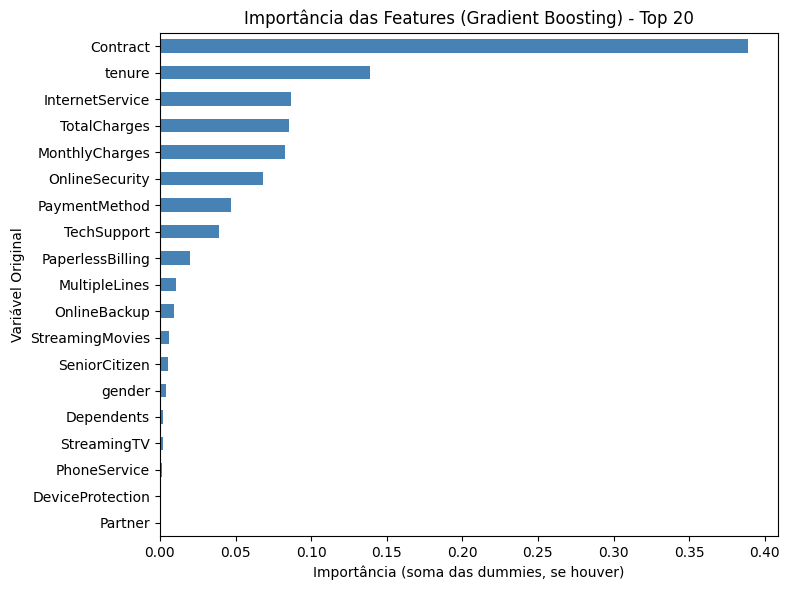

In [ ]:
import matplotlib.pyplot as plt

# Top variáveis pelo Gradient Boosting (já agregadas no imp_by_var)
top_n = 20  # ajuste o número de variáveis que deseja mostrar
imp_plot = imp_by_var.head(top_n).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
imp_plot.plot(kind="barh", color="steelblue")
plt.title(f"Importância das Features (Gradient Boosting) - Top {top_n}")
plt.xlabel("Importância (soma das dummies, se houver)")
plt.ylabel("Variável Original")
plt.tight_layout()
plt.show()


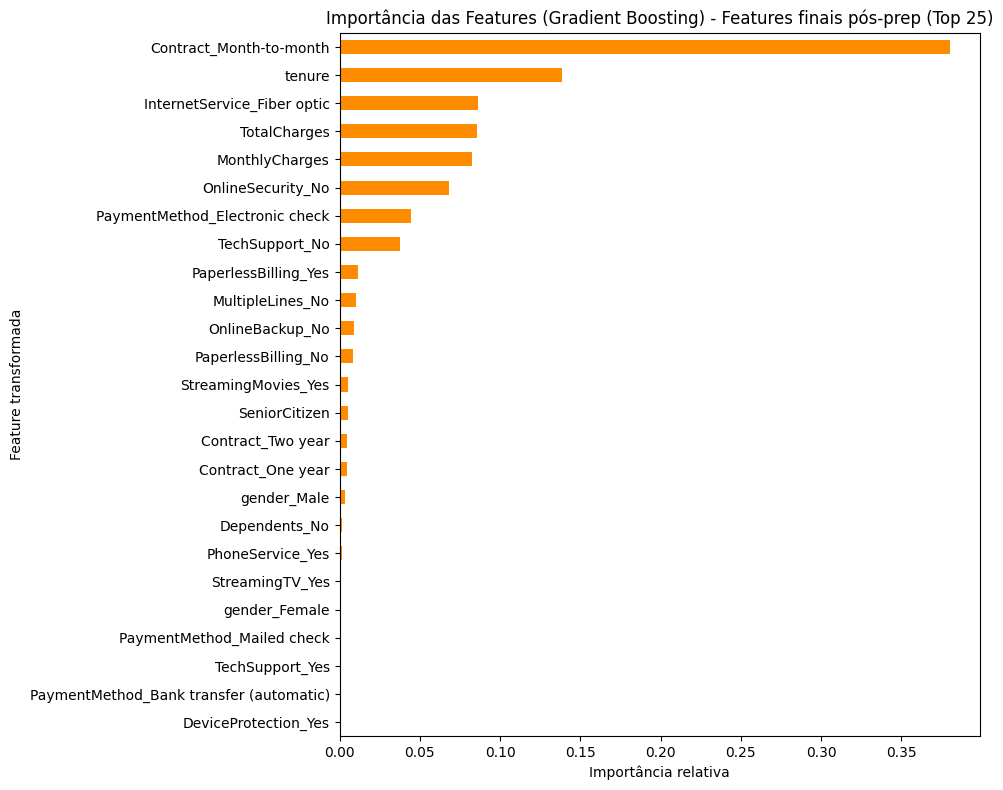

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Importâncias direto do modelo treinado (já estão no gb.feature_importances_)
imp_final = pd.Series(gb.feature_importances_, index=feature_names).sort_values(ascending=True)

# Top N
top_n = 25
imp_final_plot = imp_final.tail(top_n)

# Gráfico horizontal
plt.figure(figsize=(10, 8))
imp_final_plot.plot(kind="barh", color="darkorange")
plt.title(f"Importância das Features (Gradient Boosting) - Features finais pós-prep (Top {top_n})")
plt.xlabel("Importância relativa")
plt.ylabel("Feature transformada")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 1) Importâncias das features finais (pós-prep)
imp_final = pd.Series(gb.feature_importances_, index=feature_names)

# 2) Filtrar apenas variáveis com importância > 0
selected_features = imp_final[imp_final > 0].index.tolist()
print(f"Total de features selecionadas: {len(selected_features)}")

# 3) Criar a tabela limpa apenas com essas colunas
X_train_selected = pd.DataFrame(ABT_train, columns=feature_names)[selected_features]
X_test_selected  = pd.DataFrame(ABT_test,  columns=feature_names)[selected_features]

Y_train_fs = pd.DataFrame(y_train, columns=['Churn'])
Y_test_fs = pd.DataFrame(y_test, columns=['Churn'])

# Amostra da tabela resultante
X_train_selected.head()


Total de features selecionadas: 34


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Dependents_No,Dependents_Yes,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.441773,0.102371,-0.521976,-0.263290,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.441773,-0.711743,0.337478,-0.504815,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.441773,-0.793155,-0.809013,-0.751214,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.441773,-0.263980,0.284384,-0.173700,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.441773,-1.281624,-0.676279,-0.990851,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Salvando as tabelas com as variáveis importantes

In [ ]:
X_train_selected.to_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/abt_fs_train.csv',index=False)
X_test_selected.to_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/abt_fs_test.csv',index=False)
Y_train_fs.to_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/y_train.csv',index=False)
Y_test_fs.to_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/y_test.csv',index=False)